In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def bioreactor_odes(t, y):
    # Unpack variables ensuring values are never negative
    C_X, C_glc, C_lac, C_Ab, V = (max(1e-3, var) for var in y)

    # Unpack parameters
    (KIlac, mglc, Qp, mu_max, kd, Yxglc, Ylacglc, Kdglc) = (
         7.1, 82.3e-12, 8.18e-13, 5.17e-2, 2.32e-2, 1.33e9, 2.76e-11, 1.54
    ) 
    
    # Supplementary feed concentration (130g/L)
    cin = 722
    # Change in supplementary feedrate
    if t<60:
        vvd = 0
    elif t>60 and t<150:
        vvd = 0.05
    elif t>150 and t<220:
        vvd = 0.06   
    elif t>220: 
        vvd = 0.07
    
    Fin = vvd*V/24

    mu = mu_max * (KIlac / (KIlac + C_lac))
    mu_d = kd * (Kdglc / (Kdglc + C_glc))

    # System of ODEs
    dC_X_dt = (mu - mu_d) * C_X - Fin/V*C_X                             # Viable biomass
    dC_glc_dt = -((mu - mu_d) / Yxglc + mglc)*C_X + Fin/V*(cin-C_glc)   # Glucose
    dC_lac_dt = Ylacglc * C_X - Fin/V*C_lac                             # Lactate 
    dC_Ab_dt = Qp * C_X - Fin/V*C_Ab                                    # Monoclinical Antibody 
    dV_dt = Fin                                                         # Volume in bioreactor

    return [dC_X_dt, dC_glc_dt, dC_lac_dt, dC_Ab_dt, dV_dt]


In [13]:
# Time span and time points for simulation
# Total of 14 days of simulation with 1s of intervals
t_start = 0
t_end = 14*24
intervals = t_end*60*60
time_span = (t_start, t_end)  # Time range
time_points = np.linspace(t_start, t_end, intervals)  # Time points for evaluation (1s)

# Generate training data
results = []

# Initial conditions based on whats provided in the paper
initial_conditions = [
    [0.32e9, 41, 0, 0, 50000],]

# Loop for generating data under varying initial conditions
for init_cond in initial_conditions:  # Adjust the range for the number of conditions you want
    sol = solve_ivp(
        bioreactor_odes,          # Function defining the ODEs
        [time_points[0], time_points[-1]],                # Time range for integration
        init_cond,       # Initial conditions
        t_eval=time_points,
        method = 'BDF'            
    )
    
    condition_results = pd.DataFrame(
        np.vstack(sol.y).T,
        columns=["C_X", "C_glc", "C_lac", "C_Ab", "V"]
    )
    condition_results["Time"] = sol.t
    condition_results["Condition"] = f"Init {initial_conditions.index(init_cond) + 1}"
    results.append(condition_results)

# Convert training data to NumPy array for further processing
all_results = pd.concat(results)

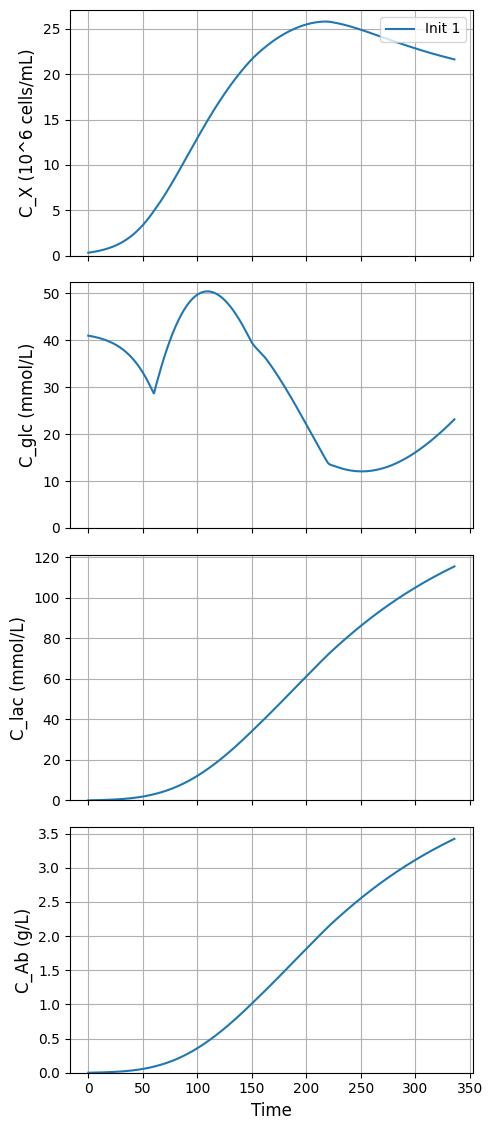

In [18]:
# Plot results in subplots
variables = ["C_X", "C_glc", "C_lac", "C_Ab"]
colors = sns.color_palette("tab10", len(initial_conditions))

fig, axes = plt.subplots(len(variables), 1, figsize=(10, 12), sharex=True)
for i, var in enumerate(variables):
    ax = axes[i]
    for idx, init_cond in enumerate(initial_conditions):
        subset = all_results[all_results["Condition"] == f"Init {idx + 1}"]
        
        if var == "C_X":
            subset[var] = subset[var] / 10**9   # converting cells/L to 10^6 cells/mL
            
        ax.plot(
            subset["Time"],
            subset[var],
            label=f"Init {idx + 1}",
            color=colors[idx]
        )
    ax.set_ylabel(f"{var} ({'10^6 cells/mL' if var == 'C_X' else 'g/L' if var == 'C_Ab' else 'mmol/L'})", fontsize=12)
    ax.grid(True)
    ax.set_ylim(bottom=0)
    if i == 0:
        ax.legend(loc="upper right", fontsize=10)

axes[-1].set_xlabel("Time", fontsize=12)
plt.tight_layout(rect=[0, 0, 0.5, 0.95])
plt.show()